# Homework 1: Information Retrieval
## Instructions
1. Students will form teams of three people each and submit a single homework for each team in the format - ID1_ID2_ID3.ipynb
2. Groups of three!
2. **Do not write your names anywhere.**
3. For the code part: 
> **Write your code only in the mentioned sections. Do not change the code of other sections**. Do not use any imports unless we say so.
4. For theoretical questions, if any - write your answer in the markdown cell dedicated to this task, in **English**.


#### Deviation from the aforementioned  instructions will lead to reduced grade
---


## Clarifications
1. The same score for the homework will be given to each member of the team.  
2. The goal of this homework is to test your understanding of the concepts presented in the lectures. \
Anyhow, we provide here detailed explanations for the code part and if you have problems - ask.
3. Questions can be sent to the forum, you are encouraged to ask questions but do so after you have been thinking about your question. 
4. The length of the empty gaps (where you are supposed to write your code) is a recommendation (the amount of space took us to write the solution) and writing longer code will not harm your grade. We do not expect you to use the programming tricks and hacks we used to make the code shorter.   
Having said that, we do encourage you to write good code and keep that in mind - **extreme** cases may be downgraded.  
We also encourage to use informative variable names - it is easier for us to check and for you to understand. 

For your convenience, , the code has a **DEBUG** mode that you may use in order to debug with toy data.  
It is recommended to solve the code in that mode (with efficiency in mind) and then run the code on all the data.
**Do not forget to file the HW with DEBUG == False**.


Since it is the first time we provide this homework please notify us if there is a bug/something is unclear, typo's exc..

5. We use Python 3.7 for programming.
6. Make sure you have all the packages and functions used in the import section. Most of it is native to Anaconda Python distribution.

### Have fun !

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
from tqdm import tqdm
from typing import List,Dict
from IPython.display import Image
from IPython.core.display import HTML 
from pathlib import Path
import statistics
import math
import scipy.stats as st
import time

In [2]:
tic = time.perf_counter() #Start timer

In [3]:
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from string import punctuation, ascii_lowercase
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilanv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ilanv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Debug
""" you can change this cell """

In [50]:
DEBUG = False
"""
Recommended to start with a small number to get a feeling for the preprocessing with prints (N_ROWS_FOR_DEBUG = 2)
later increase this number for 5*10**3 in order to see that the code runs at reasonable speed. 
When setting Debug == False, our code implements bow.fit() in 15-20 minutes according to the tqdm progress bar. Your solution is not supposed to be much further than that.
"""
N_ROWS_FOR_DEBUG = 5*10**3 

# Config

In [51]:
INPUT_FILE_PATH = Path("lyrics.csv")
BOW_PATH = Path("bow.csv")
N_ROWS = N_ROWS_FOR_DEBUG if DEBUG else None
CHUNCK_SIZE = 5 if DEBUG else 5*10**3
tqdm_n_iterations = N_ROWS//CHUNCK_SIZE +1 if DEBUG else 114*10**3//CHUNCK_SIZE + 1
COLS = [0]

## 1.1 Bag of words /TfIdf model
### Implement the following methods:

* `preprocess_sentence`: 
    * Lower case the word
    * Ignores it if it's in the stopwords list
    * Removes characters which are not in the allowed symbols
    * Stems it and appends it to the output sentence
    * Discards words with length <= 1
    
    
* `update_counts_and_probabilities`: 

    * Update self.unigram count (the amount of time each word is in the text)
    * Update self.bigram count (two consecutive word occurances)
    * Update inverted index: a dictionary with words as keys and the values is a dictionary - {'DocID' : word_count}   
    
* `compute_word_document_frequency`:

   * For each word count the number of docs it appears in. For example , for the word 'apple' -
$$\sum_{i \in docs} I(apple \in doc_i), I := Indicator function$$


* `update_inverted_index_with_tf_idf_and_compute_document_norm`:

    * Update the inverted index (which currently hold word counts) with tf idf weighing. We will compute tf by dividing with the number of words in each document. 
    * As we want to calculate the document norm, incrementally update the document norm. pay attention that later we apply sqrt to it to finish the process.

#### The result of this code is a bag of words model that already counts for TF-IDF weighing

In [52]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
allowed_symbols = set(l for l in ascii_lowercase)

In [ ]:
def preprocess_sentence(sentence : str) -> List[str]:
    output_sentence = []
    for word in word_tokenize(sentence):
        ### YOUR CODE HERE
        #Lower case the word
        word_lower = word.lower()
        
        #Ignores it if it's in the stopwords list
        if word_lower in stop_words:
            continue
        
        #Removes characters which are not in the allowed symbols
        s = ''.join(c for c in word_lower if c in allowed_symbols)
        
        #Stems it and appends it to the output sentence
        word_stem = stemmer.stem(s)
        
        #Discards words with length <= 1
        if len(word_stem)<=1:
            continue
        output_sentence.append(word_stem)

        ### END YOUR CODE
    return output_sentence
    

def get_data_chuncks() -> List[str]:
    for i ,chunck in enumerate(pd.read_csv(INPUT_FILE_PATH, usecols = COLS, chunksize = CHUNCK_SIZE, nrows = N_ROWS)):
        chunck = chunck.values.tolist()
        yield [chunck[i][0] for i in range(len(chunck))] 

class TfIdf:
    def __init__(self,  weighted_dic = None):
        self.weighted_dic = weighted_dic
        self.unigram_count =  Counter()
        self.bigram_count = Counter()
        self.document_term_frequency = Counter()
        self.word_document_frequency = {}
        self.inverted_index = {}
        self.doc_norms = {}
        self.n_docs = -1
        self.sentence_preprocesser = preprocess_sentence
        self.bow_path = BOW_PATH

    def update_counts_and_probabilities(self, sentence :List[str],document_id:int) -> None:
        sentence_len = len(sentence)
        self.document_term_frequency[document_id] = sentence_len
        for i,word in enumerate(sentence):
            ### YOUR CODE HERE
            #Update self.unigram count (the amount of time each word is in the text)
            self.unigram_count.update([word])
            
            #Update inverted index: a dictionary with words as keys and the values is a dictionary - {'DocID' : word_count}
            if word in self.inverted_index:
                self.inverted_index[word][document_id] = self.inverted_index[word].get(document_id,0) + 1 

            else:
                self.inverted_index[word] = {}
                self.inverted_index[word][document_id] = 1
            
            #Update self.bigram count (two consecutive word occurances)
            #TODO: find out what format should be used for bigram key
            if i+1<len(sentence):
                s1=word+" "+sentence[i+1]
                self.bigram_count.update([s1])
  
            ### END YOUR CODE
        
        
    def fit(self) -> None:
        for chunck in tqdm(get_data_chuncks(), total = tqdm_n_iterations):
            for sentence in chunck: #sentence is a song (string)
                self.n_docs += 1 
                if not isinstance(sentence, str):
                    continue
                sentence = self.sentence_preprocesser(sentence)
                if sentence:
                    self.update_counts_and_probabilities(sentence,self.n_docs)
        self.save_bow() # bow is 'bag of words'
        self.compute_word_document_frequency()
        self.update_inverted_index_with_tf_idf_and_compute_document_norm()
             
    def compute_word_document_frequency(self):
        for word in self.inverted_index.keys():
            ### YOUR CODE HERE
            #For each word count the number of docs it appears in
            self.word_document_frequency[word]=len(self.inverted_index[word].keys())
            ### END YOUR CODE
            
    def update_inverted_index_with_tf_idf_and_compute_document_norm(self):
        ### YOUR CODE HERE
        #tf_idf =  tf by dividing with the number of words in each document
        for word in self.inverted_index.keys():
            doc_freq_dic=self.inverted_index[word]
            # summ=sum(doc_freq_dic.values()) #num of all occurences TODO: validate this
            
            for doc in doc_freq_dic.keys():
                tf_i = doc_freq_dic[doc]/self.document_term_frequency[doc]
                
                #calculate the document norm
                self.doc_norms[doc]= self.doc_norms.get(doc,0) + doc_freq_dic[doc]**2
                    
                #calculate tf_idf
                df_i = self.word_document_frequency[word]
                self.inverted_index[word][doc] = tf_i*np.log(self.n_docs/df_i)

        ### END YOUR CODE
        for doc in self.doc_norms.keys():
            self.doc_norms[doc] = np.sqrt(self.doc_norms[doc]) 
            
    def save_bow(self):
        pd.DataFrame([self.inverted_index]).T.to_csv(self.bow_path)
                
tf_idf = TfIdf()
tf_idf.fit()

## 1.11 Bag of words model:

1. What is the computational complexity of this model, as a function of the number of docs in the corpus?
2. How can we make this code better in terms running time (parallelization or other topics you find)? 

### YOUR SOLUTION HERE
1. O(D). We checked the complexity from the fit() function. Each function that is called by fit() has a complexity that is not above m(num of words)*D(num of documents). Explanation: sentence_preprocesser - has a complexity of O(m), update_counts_and_probabilities - has a complexity of O(m), compute_word_document_frequency - has a complexity of O(m), update_inverted_index_with_tf_idf_and_compute_document_norm - has a complexity of O(m*D)-> that is why the computational complexity of this model is O(D) (as function of documents).
2. We can run the data (which is separated by chunks) on differrent computers. Each computer will go through number of chunks, and when the data retrieved - it will be united on one computer. It will reduce the running time of the code.
### END YOUR SOLUTION


## 1.2 DocumentRetriever
Not this retriever &#8595;


![dsafdsafsdafdsf](https://cdn3-www.dogtime.com/assets/uploads/2019/10/golden-cocker-retriever-mixed-dog-breed-pictures-cover-1.jpg)

### Implement the following methods:

`reduce_query_to_counts`: given a list of words returns a counter object with words as keys and counts as values.

`rank`: given a query and relevant documents calculate the similarity (cosine or inner product simialrity) between each document and the query.   
Make sure to transform the query word counts to tf idf as well. 

`sort_and_retrieve_k_best`: returns the top k documents.

In [8]:
class DocumentRetriever:
    def __init__(self, tf_idf):
        self.sentence_preprocesser = preprocess_sentence  
        self.vocab = set(tf_idf.unigram_count.keys())
        self.n_docs = tf_idf.n_docs
        self.inverted_index = tf_idf.inverted_index
        self.word_document_frequency = tf_idf.word_document_frequency
        self.doc_norms = tf_idf.doc_norms
        
    def rank(self,query: Dict[str,int], documents: Dict[str,Counter], metric: str ) -> Dict[str, float]:
        result = {} # key: DocID , value : float , simmilarity to query
        query_len = np.sum(np.array(list(query.values())))
        ### YOUR CODE HERE
        #tf_idf for query using the tf_idf formula 
        for q in query.keys():
            tf = query[q]/query_len
            idf = np.absolute(np.log(self.n_docs/self.word_document_frequency[q]))
            query[q] = tf*idf

         ### END YOUR CODE
        if metric == 'cosine':
            ### YOUR CODE HERE
            #calculate the cosine similarity
            for document in result.keys():
                print (result[document]) #TODO: Remove
                result[doc] = ((result[doc]/query_len)/self.doc_norms[doc])
                # result[document] = ((result[document])/np.sqrt(((self.doc_norms[document])**2)*((query_len)**2)))
        
        elif metric == 'inner_product':
            #product calculation
            for word in query.keys():
                for doc in documents[word].keys():
                    result[doc]=result.get(doc,0)+documents[word][doc]*query[word]
            ### END YOUR CODE
        return result
        
    
    def sort_and_retrieve_k_best(self, scores: Dict[str, float],k :int):
        ### YOUR CODE HERE 
        #sort the scores in descending order and then get the k best of them 
        sort_the_scores = sorted(scores, key=lambda k: scores[k], reverse=True)
        k_best = sort_the_scores[:k]
        return k_best
        ### END YOUR CODE

    
    def reduce_query_to_counts(self, query : List)->  Counter:
        ### YOUR CODE HERE
        #create the counter for each word from the query
        counter = Counter()
        for q in query:
            counter.update([q])
        
        return counter
        ### END YOUR CODE
        
        
    def get_top_k_documents(self,query : str, metric: str , k = 5) -> List[str]:
        query = self.sentence_preprocesser(query)
        query = [word for word in query if word in self.vocab] # filter nan 
        query_bow = self.reduce_query_to_counts(query)
        relavant_documents = {word : self.inverted_index.get(word) for word in query}
        ducuments_with_similarity = self.rank(query_bow,relavant_documents, metric)
        return self.sort_and_retrieve_k_best(ducuments_with_similarity,k)
        
dr = DocumentRetriever(tf_idf)

In [9]:
from IPython.display import HTML
query = "Better stop dreaming of the quiet life, 'cause it's the one we'll never know And quit running for that runaway bus 'cause those rosy days are few And stop apologizing for the things you've never done 'Cause time is short and life is cruel but it's up to us to change This town called malice"
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/KT6ZtUbVw1M?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

F:\Apps\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [10]:
cosine_top_k = dr.get_top_k_documents(query, 'cosine')
print(cosine_top_k)
inner_product_top_k = dr.get_top_k_documents(query, 'inner_product')
print(inner_product_top_k)

[]
[2717, 3500, 3661, 1016, 905]


In [11]:
for index, song in enumerate(pd.read_csv(INPUT_FILE_PATH,usecols = [0]).iloc[cosine_top_k]['Lyric']):
    sep = "#"*50
    print(F"{sep}\nsong #{index} \n{song} \n{sep}")

# 1.3 term statistics:
Use "tf_idf" object that we created earlier and answer the following questions:

1. How many unique words we have?
2. How many potential word bigrams we have? How many actual word bigrams we have? How do you explain this difference?
3. What is the storage size of the input file "lyrics.csv"? What is the output file (bow.csv) size? how do you explain this difference?  

In [12]:
# 1. 
### YOUR SOLUTION HERE
print("Unique words: "+ str(len(tf_idf.unigram_count.keys())))

### END YOUR SOLUTION

"""
### Your verbal solution here
The number of unique words is 387366.
### End your verbal solution here
"""

# 2.
### YOUR SOLUTION HERE
print("Actual word bigrams "+ str(len(tf_idf.bigram_count.keys())))

### END YOUR SOLUTION

"""
### Your verbal solution here
Num of potential bigrams is 387366^2 (as the num of unique words multiplied by itself). 
The reason for the difference is that when we created bigram_count dictionary,
we took the closest next word from the sentence in our corpus, which means that we have not all the possible 
combinations. That is why we have only 6303176 bigrams.

### End your verbal solution here
"""

# 3.
### YOUR SOLUTION HERE
print("Input file size: "+str(INPUT_FILE_PATH.stat().st_size))
print("Bow file size: "+str(BOW_PATH.stat().st_size))
### END YOUR SOLUTION

"""
### Your verbal solution here
The input file is bigger than bow file, because in the input file we have lots of repetitions of the same words,
not allowed symboles, unstemmed words. 
### End your verbal solution here
"""

Unique words: 16556
Actual word bigrams 208400
Input file size: 168274338
Bow file size: 2873883


'\n### Your verbal solution here\nThe input file is bigger than bow file, because in the input file we have lots of repetitions of the same words,\nnot allowed symboles, unstemmed words. \n### End your verbal solution here\n'

## 1.4 NgramSpellingCorrector
Now we will implement a Ngarm (character Ngrams) spelling corrector. That is, we have an out of vocabulary word (v) and we want to retrieve the most similar words (in our vocabulary) to this word.
we will model the similarity of two words by-

$$sim(v,w) := prior \cdot likelihood = p(w) \cdot P(v|w) $$ 
$$P(v|w) := JaccardIndex =  \frac{|X \cap Y|}{|X \cup Y|}$$

Where v is an out of vocabulary word (typo or spelling mistake), w is in a vocabulary word, X is the ngram set of v and Y is the ngram set of w.
For example, if n == 3, the set of ngrams for word "banana" is set("ban","ana","nan","ana") = {"ban","ana","nan"}

In order to do it efficently, we will first construct an index from the possible Ngrams we have seen in our corpus to the words that those Ngrams appear in, in order prevent comparing v to all of the words in our corpus.
Then, we will implement a function that computes this similarity.

* Make sure you compute the JaccardIndex efficently!

In [13]:
def get_bigrams(word):
    for ngram in nltk.ngrams(word, 2):
        yield "".join(list(ngram))
    
"""
for example - get_bigrams is a generator, which is an object we can loop on:
for ngram in get_bigrams(word):
    DO SOMETHING
"""

'\nfor example - get_bigrams is a generator, which is an object we can loop on:\nfor ngram in get_bigrams(word):\n    DO SOMETHING\n'

In [18]:
class NgramSpellingCorrector:
    def __init__(self, unigram_counts: Counter, get_n_gram: callable):
        self.unigram_counts = unigram_counts
        self.ngram_index = {}
        self.get_n_grams = get_n_gram
    
    def build_index(self) -> None:
        ### YOUR CODE HERE
        for u in self.unigram_counts.keys():
            #split the words into ngrams
            ngrams = self.get_n_grams(u)
            for g in ngrams:
                # values are sets of words
                if g in self.ngram_index:
                    self.ngram_index[g].add(u)
                else:
                    self.ngram_index[g] = {u}

        ### END YOUR CODE
        
    def get_top_k_words(self,word:str,k=5) -> tuple([List[str], Dict[str, float]]):
        ### YOUR CODE HERE
        candidate_dic = {}
        word_ngrams = set(self.get_n_grams(word))
        unigram_sum = sum(self.unigram_counts.values())
        for ngram in self.get_n_grams(word):
            #get potential words - words that contain simmilar n-grams
            for pot_word in self.ngram_index[ngram]:
                if pot_word not in candidate_dic.keys():
                    #calculate JaccardIndex
                    pot_ngrams = set(self.get_n_grams(pot_word))
                    inter = pot_ngrams & word_ngrams
                    union = pot_ngrams | word_ngrams
                    jaccard_index = len(inter)/len(union)
                    candidate_dic[pot_word] = jaccard_index
        #return k best results
        res_dic = dict(sorted(candidate_dic.items(), key=lambda x: x[1], reverse=True)[:k])
        res_list = list(res_dic.keys())
        return res_list,res_dic
        ### END YOUR CODE


class BigramSpellingCorrector(NgramSpellingCorrector):
    def __init__(self, unigram_counts: Counter):
        super().__init__(unigram_counts, get_bigrams)

In [19]:
out_of_vocab_word = 'acress'
bigram_spelling_corrector = BigramSpellingCorrector(tf_idf.unigram_count)
bigram_spelling_corrector.build_index()
candidate_words, scores = bigram_spelling_corrector.get_top_k_words(out_of_vocab_word)

In [20]:
candidate_words

['actress', 'acess', 'crest', 'dress', 'press']

In [22]:
for word in candidate_words:
    print(f'The jaccared score for the word {word} is {round(scores[word],2)}')

The jaccared score for the word actress is 0.57
The jaccared score for the word acess is 0.5
The jaccared score for the word crest is 0.5
The jaccared score for the word dress is 0.5
The jaccared score for the word press is 0.5


## 1.5 Zipf's law 
For this part of the assignment, you will not ignore the “stop words” in advance, but rather take a data-driven approach. you will first create a dictionary with keys representing the words in the corpus and values representing how many times each word appears.

Using a simple visualization (scatter plot), you will then check whether the frequency of the words corresponds to Zipf's law.  Once we see that this is indeed the case, we'll try to display the graph on a logarithmic scale (both x and y axis) and see if we can get a linear trend.

Each word should then weighted according to its frequency, so that the words that appear most often are given a lower weight, and so on for the words whose frequency is the lowest.

So how we are going to do that?
You will standardize all the frequency values in the dictionary and after that, they will be re-weighted. If the value of the word is less than zero after standardization, you will calculate P(X <=Z) and if the value of the word is greater than 0, you will calculate 1 - P (X <= Z), and this will be the weight for every word.

Now you will multiply the standard “tf” calculation we made at the beginning of the assignment by another coefficient, which is the weight we just calculated.

Lastly, we will perform the same query you performed in the previous part of the assignment and check if the returned documents are identical or different.


In [23]:
#Override preprocess_sentence function in such a way that stop words are not ignored
def preprocess_sentence(sentence : str) -> List[str]:
    output_sentence = []
    for word in word_tokenize(sentence):
        ### YOUR CODE HERE
        #Lower case the word
        word_lower = word.lower()
        #Removes characters which are not in the allowed symbols
        s = ''.join(c for c in word_lower if c in allowed_symbols)
        #Stems it and appends it to the output sentence
        word_stem = stemmer.stem(s)
        #Discards words with length <= 1
        if len(word_stem)<=1:
            continue
        output_sentence.append(word_stem)
        ### END YOUR CODE
    return output_sentence

In [24]:
tf_idf_2 = TfIdf()
tf_idf_2.fit()

100%|█████████▉| 1000/1001 [00:37<00:00, 26.64it/s]


In [25]:
totalFrequency = tf_idf_2.unigram_count

def find_k_most_frequant_words(k : int, totalFrequency: Dict[str,int]) -> Dict[str,int]:
    ### YOUR CODE HERE
    top_k_frequant_words = dict(sorted(totalFrequency.items(), key=lambda x: x[1], reverse=True)[:k])
    ### END YOUR CODE
    return top_k_frequant_words
    
top_5_frequant_words = find_k_most_frequant_words(5, totalFrequency)

In [26]:
top_5_frequant_words

{'the': 44588, 'you': 43885, 'to': 25719, 'and': 25293, 'it': 20635}

### Plot Word Frequency - scatterplot

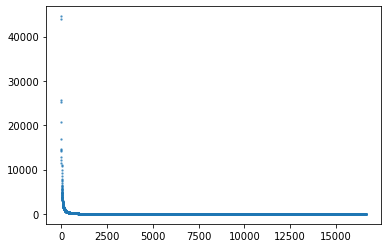

In [28]:
word_id = range(1, len(totalFrequency)+1)
frequency_values = sorted(totalFrequency.values(),reverse=True)

plt.scatter(word_id, frequency_values, s=2, alpha=0.6)
plt.show()

In [29]:
#Does the plot follow Zips' law?

"""
### Your verbal solution here
Yes, we notice a long tail distribution as we saw in lecture. Furthermore we can see a linear line in the log-log scale plot
### End your verbal solution here
"""

'\n### Your verbal solution here\nYes, we notice a long tail distribution as we saw in lecture. Furthermore we can see a linear line in the log-log scale plot\n### End your verbal solution here\n'

### Plot Word Frequency - scatterplot - log scale

<function matplotlib.pyplot.show(close=None, block=None)>

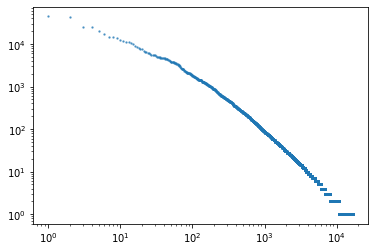

In [30]:
 ### YOUR CODE HERE
plt.scatter(word_id, frequency_values, s=2, alpha=0.6)
plt.yscale('log')
plt.xscale('log')
plt.show

### END YOUR CODE

### Data standartization and reweightening

#### Standartization# 

In [31]:
mean = statistics.mean(frequency_values)
std =math.sqrt(statistics.variance(frequency_values))

In [32]:
def standartization(totalFrequency, mean, std) -> Dict[str, int]:
    standardized_dic = {}
    ### YOUR CODE HERE
    standardized_dic = {x: (totalFrequency[x]-mean)/std for x in totalFrequency}
    ### END YOUR CODE
    return standardized_dic

standardized_dic = standartization(totalFrequency, mean, std)

In [33]:
def calc_probability_of_zscore(standardized_dic) -> Dict[str,int]:
    weighted_dic = {}
    for key in standardized_dic.keys():
        if  standardized_dic[key] <= 0:
            ### YOUR CODE HERE
                weighted_dic[key] = st.norm.cdf(standardized_dic[key])
            ### END YOUR CODE
        else:
            ### YOUR CODE HERE
                weighted_dic[key] = 1 - st.norm.cdf(standardized_dic[key])
            ### END YOUR CODE
    return weighted_dic

weighted_dic = calc_probability_of_zscore(standardized_dic)

In [34]:
#Override the function update_inverted_index_with_tf_idf_and_compute_document_norm in such a way that you multiply the original tf by the weight of the word
class WeightedTfIdf(TfIdf):
    def update_inverted_index_with_tf_idf_and_compute_document_norm(self):
        ### YOUR CODE HERE
        for word in self.inverted_index.keys():
            doc_freq_dic = self.inverted_index[word]
            
            for doc in doc_freq_dic.keys():
                tf_i = doc_freq_dic[doc]/self.document_term_frequency[doc]
                
                #calculate the document norm
                self.doc_norms[doc]= self.doc_norms.get(doc,0) + doc_freq_dic[doc]**2
                    
                #calculate tf*zscore
                df_i = self.word_document_frequency[word]
                self.inverted_index[word][doc] = tf_i * self.weighted_dic[word]

        ### END YOUR CODE
        for doc in self.doc_norms.keys():
            self.doc_norms[doc] = np.sqrt(self.doc_norms[doc]) 
        ### END YOUR CODE

In [35]:
weightedTfIdf = WeightedTfIdf(weighted_dic)
weightedTfIdf.fit()

100%|█████████▉| 1000/1001 [00:38<00:00, 26.08it/s]


In [36]:
weighted_dr = DocumentRetriever(weightedTfIdf)

In [37]:
query = "Better stop dreaming of the quiet life, 'cause it's the one we'll never know And quit running for that runaway bus 'cause those rosy days are few And stop apologizing for the things you've never done 'Cause time is short and life is cruel but it's up to us to change This town called malice"

In [38]:
cosine_top_k = weighted_dr.get_top_k_documents(query, 'cosine')
print(cosine_top_k)
inner_product_top_k = weighted_dr.get_top_k_documents(query, 'inner_product')
print(inner_product_top_k)

[]
[3661, 2717, 905, 3500, 1016]


In [ ]:
#Is there any similarity between the documents retrieved? Please explain.

"""
### Your verbal solution here


TODO


### End your verbal solution here
"""

# 1.6 bigram's language model

#### Following on from section 1.4, this section discusses spelling corrections.
#### Documents were requested for the following query:

"the bad acress played role on the show"

#### It can be seen from section 1.4 that acress does not appear in the corpus and also received  five candidate words that could be considered its replacement. As soon as the sentence is given, it is possible and even desirable to consider the context in order to determine what candidate word to use. To do so, we will use bigram's language model to calculate P(w). Finally, we return the word with the best weighted score by multiplying P(w) by the jaccard index of the word. After you've done that, discuss the results.

#### Notice: only p(w) is calculated in this case using the bigram language model a. You dont need to calculate p(x|w).

In [39]:
the_uncorrect_sentense = "the bad acress played role on the show"
#continue from here
#use tf_idf object from section 1.1!!
err_word = 'acress'
query = preprocess_sentence(the_uncorrect_sentense)
err_index = query.index(err_word)
prev = query[err_index-1]
after = query[err_index+1]
# get candidates and jaccard score 
candidate_words, scores = bigram_spelling_corrector.get_top_k_words(out_of_vocab_word)
bigram_score_dic = {}
bigram_sum = sum(tf_idf.bigram_count.values())
# Calculate score for each candidate
for pot_word in candidate_words:
    jaccard_score = scores[pot_word]
    p_prev = tf_idf.bigram_count[prev + " " + err_word]/bigram_sum
    p_after = tf_idf.bigram_count[err_word + " " + after]/bigram_sum
    bigram_score_dic[pot_word] = p_prev*p_after*jaccard_score

best_candidate = max(bigram_score_dic,key=bigram_score_dic.get)
print(f'The best candidate word is : {best_candidate}')

The best candidate word is : actress


In [49]:
bigram_score_dic

{'actress': 0.0, 'acess': 0.0, 'crest': 0.0, 'dress': 0.0, 'press': 0.0}

In [40]:
bigram_score_dic

{'actress': 0.0, 'acess': 0.0, 'crest': 0.0, 'dress': 0.0, 'press': 0.0}

# The End - You did it!

In [ ]:
#The time it took to run the entire code
toc = time.perf_counter()
print(f"The time it took to run the entire code is: {(toc - tic)/60} minuts")